<a href="https://colab.research.google.com/github/roshmita/amazon-stock-lstm/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import yfinance as yf
from datetime import timedelta

### Fetching Data from Yahoo Finance

In [45]:
def fetch_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="5y")
    return hist

ticker = "AMZN"  # Example ticker
data = fetch_data(ticker)

# Convert the index to just date (remove time part)
data.index = data.index.date

### Exploratory Data Analysis

In [46]:
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2025-03-12,200.720001,201.520004,195.289993,198.889999,43679300,0.0,0.0
2025-03-13,198.169998,198.880005,191.820007,193.889999,41270800,0.0,0.0
2025-03-14,197.410004,198.649994,195.320007,197.949997,38096700,0.0,0.0
2025-03-17,198.770004,199.000000,194.320007,195.740005,47341800,0.0,0.0
2025-03-18,192.520004,194.000000,189.380005,192.820007,40355500,0.0,0.0


In [47]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2020-03-19,93.000000,97.250000,91.632500,94.046501,207998000,0.0,0.0
2020-03-20,96.315498,97.849998,91.036499,92.304497,196358000,0.0,0.0
2020-03-23,91.387497,95.970001,90.599998,95.141502,156170000,0.0,0.0
2020-03-24,97.574997,97.750000,95.016998,97.004997,142942000,0.0,0.0
2020-03-25,96.034500,97.513000,94.289001,94.292000,129582000,0.0,0.0


In [48]:
data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03,1256.0,1256.000000
mean,151.854449,153.684616,149.857601,151.803638,6.579967e+07,0.0,0.015924
std,33.576680,33.636159,33.363848,33.507634,3.185088e+07,0.0,0.564333
min,82.800003,83.480003,81.430000,81.820000,1.500750e+07,0.0,0.000000
25%,126.179998,128.132500,124.466749,126.384998,4.433550e+07,0.0,0.000000
50%,156.825500,158.773003,154.707245,156.667999,5.859565e+07,0.0,0.000000
75%,173.376251,174.803001,171.581871,173.133507,7.773148e+07,0.0,0.000000
max,239.020004,242.520004,238.029999,242.059998,2.726620e+08,0.0,20.000000


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1256 entries, 2020-03-19 to 2025-03-18
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1256 non-null   float64
 1   High          1256 non-null   float64
 2   Low           1256 non-null   float64
 3   Close         1256 non-null   float64
 4   Volume        1256 non-null   int64  
 5   Dividends     1256 non-null   float64
 6   Stock Splits  1256 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 110.8+ KB


<Axes: >

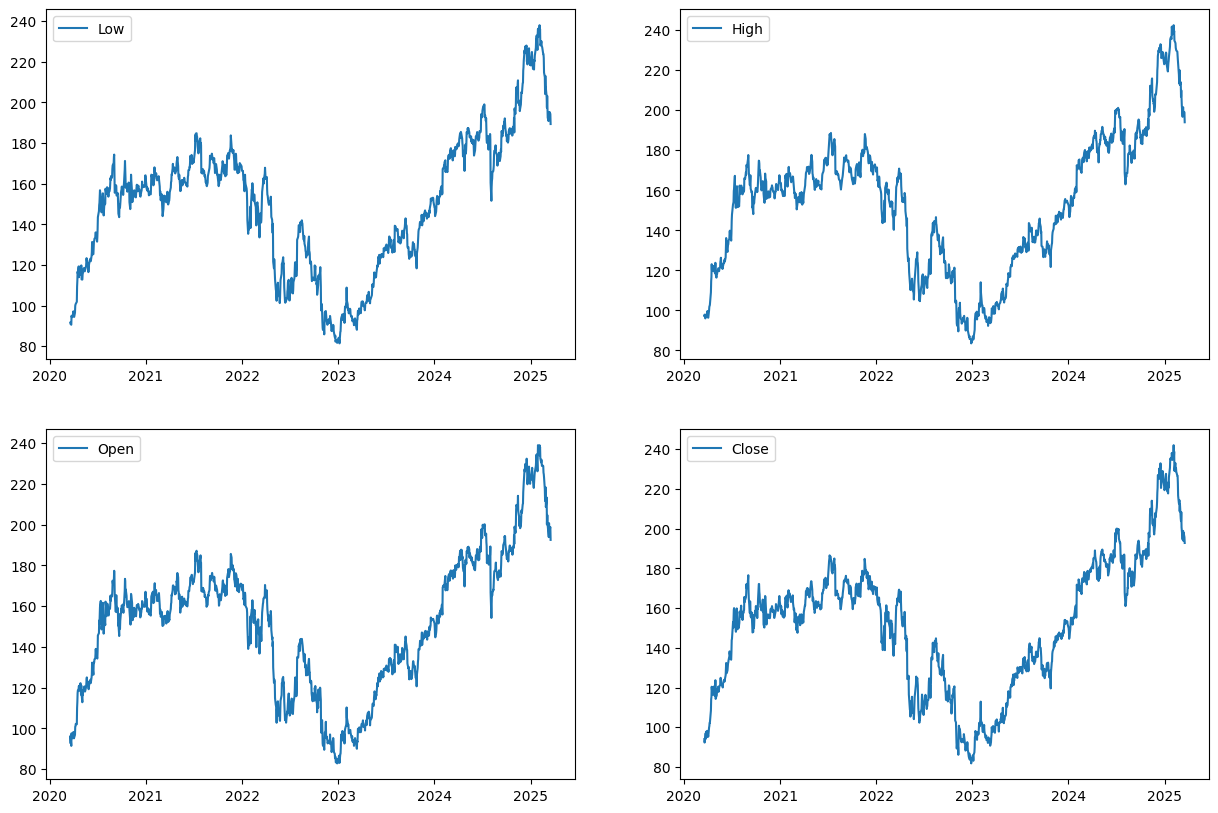

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
data[['Low']].plot(ax = axes[0,0])
data[['High']].plot(ax = axes[0,1])
data[['Open']].plot(ax = axes[1,0])
data[['Close']].plot(ax = axes[1,1])

In [51]:
data['Daily Return'] = data['Close'].pct_change()
data['Spread'] = data['High'] - data['Low']

In [52]:
ma_day = [10, 15, 30, 60]
for ma in ma_day:
    column_name = f"MA_{ma}days"
    data[column_name] = data['Close'].rolling(ma).mean()

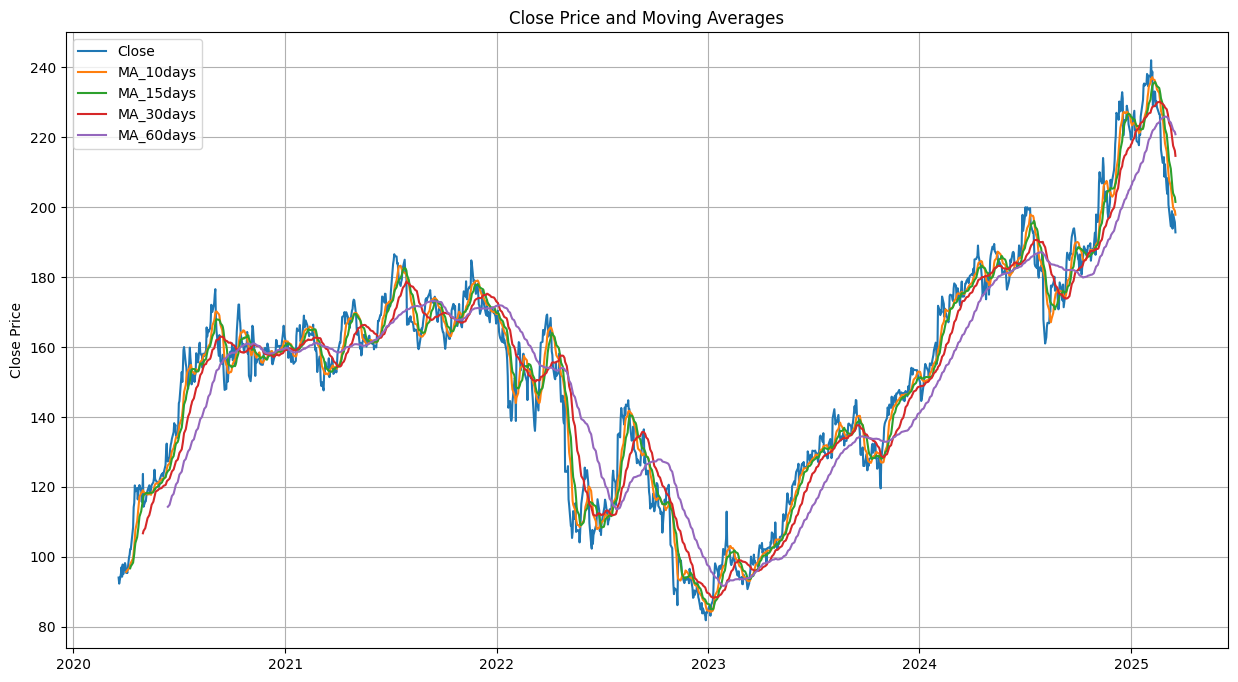

In [53]:
data[['Close', 'MA_10days', 'MA_15days', 'MA_30days', 'MA_60days']].plot(figsize=(15, 8))
plt.title('Close Price and Moving Averages')
plt.ylabel('Close Price')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [54]:
cols = ["Open", "Close", "Volume", "High", "Low", 'Daily Return', 'Spread']
correlation_matrix = data[cols].corr()
correlation_matrix['Close']

,Close
Open,0.997207
Close,1.000000
Volume,-0.340332
High,0.998761
Low,0.998854
Daily Return,0.031374
Spread,0.153477


In [55]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return,Spread,MA_10days,MA_15days,MA_30days,MA_60days
2020-03-19,93.000000,97.250000,91.632500,94.046501,207998000,0.0,0.0,NaN,5.617500,NaN,NaN,NaN,NaN
2020-03-20,96.315498,97.849998,91.036499,92.304497,196358000,0.0,0.0,-0.018523,6.813499,NaN,NaN,NaN,NaN
2020-03-23,91.387497,95.970001,90.599998,95.141502,156170000,0.0,0.0,0.030735,5.370003,NaN,NaN,NaN,NaN
2020-03-24,97.574997,97.750000,95.016998,97.004997,142942000,0.0,0.0,0.019587,2.733002,NaN,NaN,NaN,NaN
2020-03-25,96.034500,97.513000,94.289001,94.292000,129582000,0.0,0.0,-0.027968,3.223999,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Amazon Daily Returns')

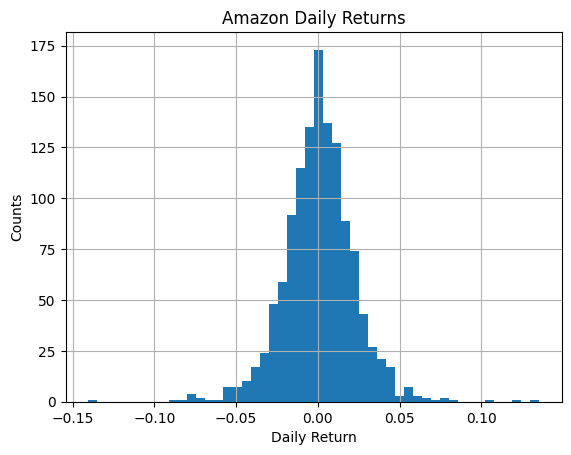

In [56]:
data['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('Amazon Daily Returns')

In [57]:
# Normalize and create sequences
def create_sequences(data, seq_length):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    sequences, labels = [], []
    for i in range(len(data_scaled) - seq_length):
        sequences.append(data_scaled[i:i+seq_length])
        labels.append(data_scaled[i+seq_length, 0])
    return np.array(sequences), np.array(labels), scaler

In [72]:
df = data[['Close', 'Open', 'High', 'Low']]

In [73]:
# Load & preprocess data
seq_length = 60  # Use past 60 days to predict next day
X, y, scaler = create_sequences(df.values, seq_length)

In [74]:
X.shape

(1196, 60, 4)

In [75]:
# Train-val-test split
train_split = int(0.8 * len(X))
val_split = int(0.9 * len(X))
X_train, X_val, X_test = X[:train_split], X[train_split:val_split], X[val_split:]
y_train, y_val, y_test = y[:train_split], y[train_split:val_split], y[val_split:]

In [76]:
print(X_train.shape, X_val.shape, X_test.shape)

(956, 60, 4) (120, 60, 4) (120, 60, 4)


In [77]:
print(y_train.shape, y_val.shape, y_test.shape)

(956,) (120,) (120,)


In [78]:
# Build LSTM Model
model = Sequential([
    LSTM(units = 128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  # Adjust input_shape
    Dropout(0.2),
    LSTM(units = 128, return_sequences=True),
    Dropout(0.2),
    LSTM(units = 64, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(1)  # Output layer - Adjust to match y_train shape
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 60, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 60, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,201 (981.25 KB)

 Trainable params: 251,201 (981.25 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10)

In [80]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[early_stop, lr_scheduler])

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - loss: 0.0438 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 323ms/step - loss: 0.0030 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - loss: 0.0026 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - loss: 0.0024 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 274ms/step - loss: 0.0024 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - loss: 0.0023 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.0021 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - loss: 0.0021 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - loss: 0.0018 - val_loss: 0.0020 - learning_rate: 0.00

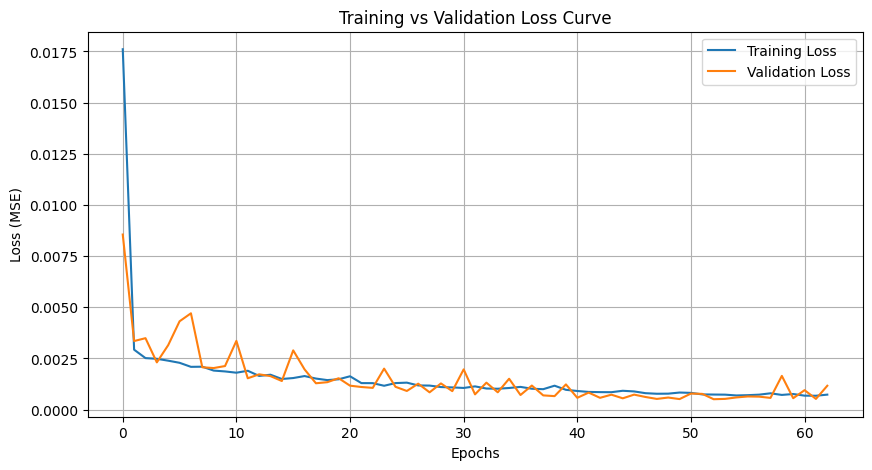

In [81]:
def plot_loss(history):
    """
    Plots the training and validation loss curves.

    Parameters:
    history : Keras History object from model.fit()
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call this function after training your model
plot_loss(history)

In [82]:
# Evaluate model on test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
y_pred = model.predict(X_test)

# Create an empty array matching the original feature count (5 columns)
y_pred_full = np.zeros((y_pred.shape[0], scaler.data_min_.shape[0]))  # Ensure correct column count

# Assign Close price predictions to the correct column (last one)
y_pred_full[:, -1] = y_pred[:, 0]

# Apply inverse transform
y_pred_actual = scaler.inverse_transform(y_pred_full)[:, -1]  # Extract Close price

# Do the same for y_test (actual values)
y_test_full = np.zeros((y_test.shape[0], scaler.data_min_.shape[0]))
y_test_full[:, -1] = y_test.reshape(-1)  # Assign actual Close prices

# Convert back to original scale
y_test_actual = scaler.inverse_transform(y_test_full)[:, -1]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0011    
Test Loss: 0.0012783046113327146
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


In [83]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error on test set: ", mae)

Mean absolute error on test set:  0.028898348167539986


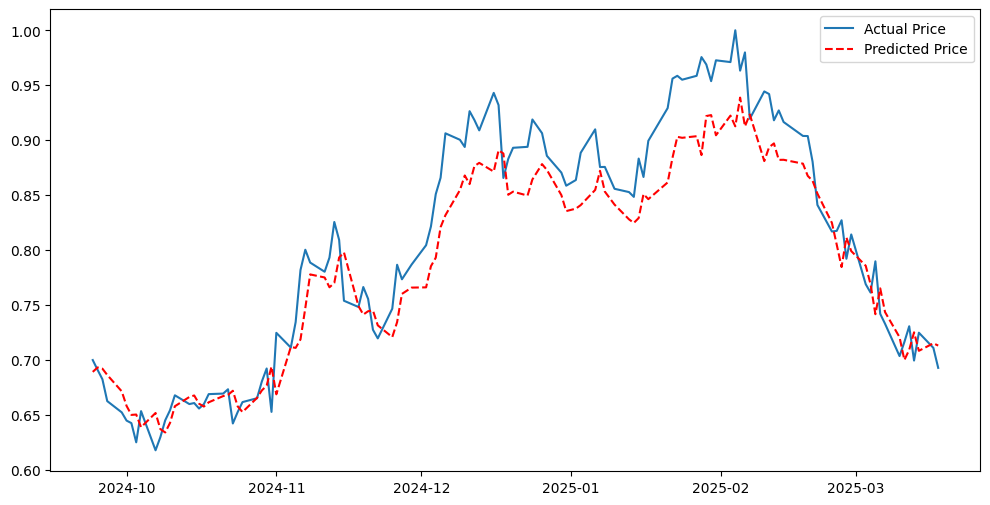

In [84]:
# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label="Actual Price")
plt.plot(df.index[-len(y_pred):], y_pred, label="Predicted Price", color='red', linestyle='dashed')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


<ipython-input-85-2e3e70dbe251>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_seq[-1, 0] = pred  # Only update Close price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


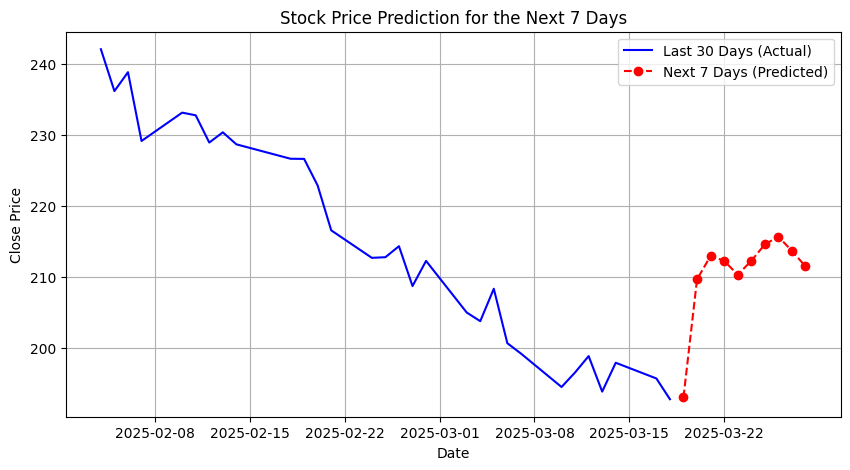

,Date,Predicted Close Price
0,2025-03-19,193.086555
1,2025-03-20,209.686809
2,2025-03-21,212.979325
3,2025-03-22,212.298478
4,2025-03-23,210.332878
5,2025-03-24,212.271950
6,2025-03-25,214.600534


In [85]:
def predict_future(n_days, last_sequence, model, scaler):
    """
    Predicts future stock prices for the next n_days.

    Parameters:
    - n_days : int, number of days to predict
    - last_sequence : numpy array, last available sequence for prediction
    - model : trained LSTM model
    - scaler : fitted MinMaxScaler for inverse transformation

    Returns:
    - future_dates : list, generated future dates
    - future_prices : numpy array, predicted prices (in original scale)
    """
    future_preds = []
    current_seq = last_sequence.copy()

    for _ in range(n_days):
        pred = model.predict(current_seq.reshape(1, seq_length, current_seq.shape[1]))  # Dynamic shape handling
        future_preds.append(pred[0, 0])

        # Shift and update only the Close price (last column)
        current_seq = np.roll(current_seq, -1, axis=0)
        current_seq[-1, 0] = pred  # Only update Close price

    # Convert predictions back to original scale
    future_preds_full = np.zeros((n_days, current_seq.shape[1]))  # Empty array with same feature count
    future_preds_full[:, -1] = future_preds  # Assign predicted Close prices
    future_prices = scaler.inverse_transform(future_preds_full)[:, -1]  # Extract Close price

    # Generate future dates
    last_date = df.index[-1]
    future_dates = [last_date + timedelta(days=i) for i in range(1, n_days + 1)]

    return future_dates, future_prices

# Predict next 7 days
future_dates, future_prices = predict_future(10, X_test[-1], model, scaler)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(df.index[-30:], df["Close"].values[-30:], label="Last 30 Days (Actual)", color="blue")
plt.plot(future_dates, future_prices, label="Next 7 Days (Predicted)", color="red", linestyle="dashed", marker="o")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Prediction for the Next 7 Days")
plt.legend()
plt.grid(True)
plt.show()

# Print predicted future prices with dates
future_predictions_df = pd.DataFrame({"Date": future_dates, "Predicted Close Price": future_prices.flatten()})
future_predictions_df.head(7)